# Imports + Setup

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from helper_methods import *

plt.rcParams.update({
    'figure.figsize':(11,7), 
    'figure.dpi':120
})
image_dest = 'results_images/'
visual_specs={'fontsize':14, 'palette':'Greys', 'saturation':0.5}
fontsize = visual_specs['fontsize']
palette = visual_specs['palette']
datapath = '../Data/'

id_col = 'SPA_PER_ID'
event_col = 'CMIS_MATCH'

# Load Predictions

In [2]:
filename = 'output.pickle'
summary, models, features, data_retention_stats = load_model_output(datapath+filename)

print(filename + ' Features')
print_list(features)

print("\n" + filename + ' Data Retention Stats')
print_dict(data_retention_stats)

output.pickle Features
PAST_DUE
TOTAL_CUR_BALANCE
NUM_PREM_FOR_PER
BREAK_ARRANGEMENT
NUM_PER_FOR_PREM
SPA_PER_ID
CMIS_MATCH

output.pickle Data Retention Stats
Rows: 3674901
Rows (% of Billing): 96.17435584999222
Accounts: 96768
Accounts (% of Billing): 98.68847777755114
Premisses: 64728
Premisses (% of Billing): 99.86577181208054
People: 91591
People (% of Service Agreements): 37.63462067888679
Positive Cases: 357
Positive Cases (% of Service Agreements): 18.449612403100776
Negative Cases: 91234
Negative Cases (% of Service Agreements): 37.78838108965597


# ROC Curve

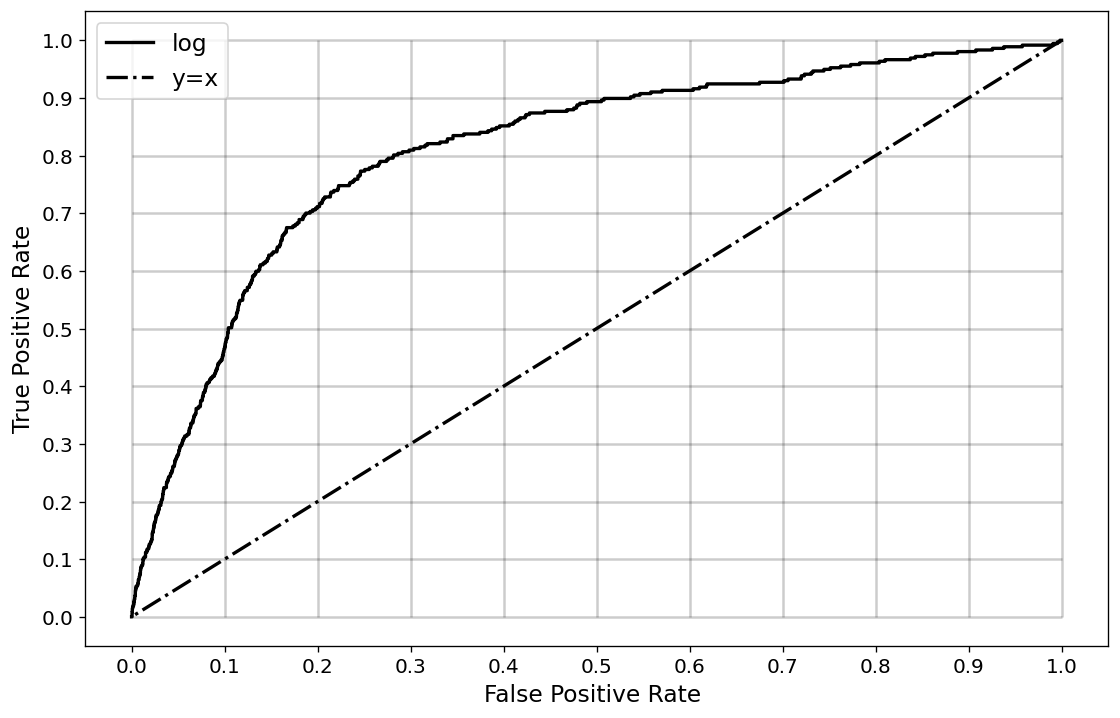

In [3]:
linewidth = 2
color = 'black'
alpha=0.2

plt.plot(summary['fpr'], summary['tpr'], color='black', label='log', linestyle='-', linewidth=linewidth)

# Refernce line
plt.plot([1, 0], [1, 0], color='black', label='y=x', linestyle='dashdot', linewidth=linewidth)

ticks = np.arange(0, 1.1, 0.1)
plt.hlines(y=ticks, xmin=0, xmax=1, colors=color, alpha=alpha)
plt.vlines(x=ticks, ymin=0, ymax=1, colors=color, alpha=alpha)
plt.xlabel('False Positive Rate ', fontsize=fontsize)
plt.xticks(ticks, fontsize=fontsize-2)
plt.ylabel('True Positive Rate', fontsize=fontsize)
plt.yticks(ticks, fontsize=fontsize-2)
plt.legend(fontsize=fontsize)
plt.savefig(fname=image_dest+'ROC.png', bbox_inches='tight')
plt.show()

# Model Parameters

In [4]:
float_format = "%.3f"
features_to_drop = ['SPA_PER_ID', 'CMIS_MATCH']
xname = [x for x in features if x not in features_to_drop]

In [5]:
def avg_params(models, xname):
    params = np.zeros(shape=len(xname))
    conf_int = np.zeros(shape=(len(xname), 2))
    k = len(models)
    for model in models:
        params = np.add(params, model.params)
        conf_int = np.add(conf_int, model.conf_int())
    params = np.divide(params, k)
    conf_int = np.divide(conf_int, k)
    df = pd.DataFrame(data={'Feature': xname,
                            'Mean Coeff': params,
                            'Mean OR': np.exp(params),
                            'Mean [0.025': np.exp(conf_int[:, 0]),
                            'Mean 0.975]': np.exp(conf_int[:, 1])})
    return df

In [6]:
avg_params = avg_params(models=models, xname=xname)

print(avg_params.to_latex(float_format=float_format, index=False))

\begin{tabular}{lrrrr}
\toprule
          Feature &  Mean Coeff &  Mean OR &  Mean [0.025 &  Mean 0.975] \\
\midrule
         PAST\_DUE &       0.406 &    1.501 &        1.499 &        1.502 \\
TOTAL\_CUR\_BALANCE &       0.001 &    1.001 &        1.001 &        1.001 \\
 NUM\_PREM\_FOR\_PER &      -0.992 &    0.371 &        0.369 &        0.372 \\
BREAK\_ARRANGEMENT &       0.800 &    2.225 &        2.195 &        2.256 \\
 NUM\_PER\_FOR\_PREM &       0.078 &    1.081 &        1.079 &        1.084 \\
\bottomrule
\end{tabular}



# Analyze Performance

## Area Under the Curve (AUC)

In [7]:
reporting_metrics = ['threshold', 'tpr', 'fpr', 'ppv', 'accuracy', 'balanced', 'f-1']
print(f'AUC: {summary["auc"].loc[0]}')

AUC: 0.8098265063966705


## Threshold = 0.5

In [8]:
delta = 0.001
threshold_target = 0.5

print(summary[abs(summary['threshold'] - threshold_target) < delta][reporting_metrics].head().
      to_latex(float_format=float_format, index=False))

\begin{tabular}{rrrrrrr}
\toprule
 threshold &   tpr &   fpr &   ppv &  accuracy &  balanced &   f-1 \\
\midrule
     0.501 & 0.812 & 0.307 & 0.812 &     0.694 &     0.753 & 0.812 \\
     0.501 & 0.812 & 0.307 & 0.812 &     0.694 &     0.753 & 0.812 \\
\bottomrule
\end{tabular}



## Compare to Byrne's 2020 study
TPR = 0.778, PPV = 0.117

In [9]:
delta = 0.0025
tpr_target = 0.778

print(summary[abs(summary['tpr'] - tpr_target) < delta][reporting_metrics].
      to_latex(float_format=float_format, index=False))

\begin{tabular}{rrrrrrr}
\toprule
 threshold &   tpr &   fpr &   ppv &  accuracy &  balanced &   f-1 \\
\midrule
     0.560 & 0.776 & 0.251 & 0.776 &     0.749 &     0.763 & 0.776 \\
     0.554 & 0.776 & 0.256 & 0.776 &     0.745 &     0.760 & 0.776 \\
     0.554 & 0.779 & 0.256 & 0.779 &     0.745 &     0.762 & 0.779 \\
     0.550 & 0.779 & 0.259 & 0.779 &     0.741 &     0.760 & 0.779 \\
\bottomrule
\end{tabular}



## Compare to Shinn's 2013 Study
### Full Model
TPR = 0.90, FPR = 0.610  
Captured Below  
## Compare to Toros' 2019 study
### Unemployed Worker Model  
TPR = 0.90, FPR = 0.297  
Captured Below
### Youth Receiving Public Assistance Model  
TPR = 0.90, FPR = 0.364  
Captured Below
## Compare to Hong's 2018 study
TPR = 0.90, FPR = 0.69  
Captured Below
## At TPR = 90.0%

In [10]:
delta = 0.001
tpr_target = 0.90

print(summary[abs(summary['tpr'] - tpr_target) < delta][reporting_metrics].
      to_latex(float_format=float_format, index=False))

\begin{tabular}{rrrrrrr}
\toprule
 threshold &   tpr &   fpr &   ppv &  accuracy &  balanced &   f-1 \\
\midrule
     0.410 & 0.899 & 0.508 & 0.899 &     0.494 &     0.696 & 0.899 \\
     0.410 & 0.899 & 0.508 & 0.899 &     0.493 &     0.696 & 0.899 \\
     0.410 & 0.899 & 0.508 & 0.899 &     0.493 &     0.696 & 0.899 \\
     0.410 & 0.899 & 0.509 & 0.899 &     0.492 &     0.695 & 0.899 \\
     0.409 & 0.899 & 0.510 & 0.899 &     0.492 &     0.695 & 0.899 \\
     0.409 & 0.899 & 0.510 & 0.899 &     0.491 &     0.694 & 0.899 \\
     0.409 & 0.899 & 0.510 & 0.899 &     0.491 &     0.694 & 0.899 \\
     0.409 & 0.899 & 0.512 & 0.899 &     0.490 &     0.694 & 0.899 \\
     0.409 & 0.899 & 0.512 & 0.899 &     0.489 &     0.694 & 0.899 \\
     0.409 & 0.899 & 0.513 & 0.899 &     0.488 &     0.693 & 0.899 \\
     0.409 & 0.899 & 0.514 & 0.899 &     0.488 &     0.693 & 0.899 \\
     0.409 & 0.899 & 0.514 & 0.899 &     0.488 &     0.693 & 0.899 \\
     0.409 & 0.899 & 0.514 & 0.899 &     0.488 

## Compare to VanBerlo's 2020 study
TPR = 0.921, PPV = 0.651

In [11]:
delta = 0.00057
tpr_target = 0.921

print(summary[abs(summary['tpr'] - tpr_target) < delta][reporting_metrics].
      to_latex(float_format=float_format, index=False))

\begin{tabular}{rrrrrrr}
\toprule
 threshold &   tpr &   fpr &   ppv &  accuracy &  balanced &   f-1 \\
\midrule
     0.387 & 0.922 & 0.618 & 0.922 &     0.384 &     0.652 & 0.922 \\
     0.387 & 0.922 & 0.618 & 0.922 &     0.384 &     0.652 & 0.922 \\
     0.387 & 0.922 & 0.618 & 0.922 &     0.384 &     0.652 & 0.922 \\
     0.387 & 0.922 & 0.618 & 0.922 &     0.384 &     0.652 & 0.922 \\
     0.387 & 0.922 & 0.618 & 0.922 &     0.384 &     0.652 & 0.922 \\
     0.387 & 0.922 & 0.619 & 0.922 &     0.383 &     0.651 & 0.922 \\
     0.387 & 0.922 & 0.619 & 0.922 &     0.383 &     0.651 & 0.922 \\
     0.387 & 0.922 & 0.619 & 0.922 &     0.383 &     0.651 & 0.922 \\
\bottomrule
\end{tabular}

